# EE5175 Lab 2 : Occlusion Detection
Author: Kishore Rajendran [EE20B064]

Date: 12 Feb 2024

In [2]:
# Importing required libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

Bilinear Interpolation

In [3]:
# Given the transformed source image pixel coordinates and the image, apply bilinear interpolation to return correct target intensity
def bilinear_interpolation(xs, ys, img):
    xs_i = np.floor(xs)
    ys_i = np.floor(ys)
    a = xs - xs_i
    b = ys - ys_i
    # If the transformed pixel value is out of bounds
    if xs_i < 0 or xs_i >= img.shape[0] - 1 or ys_i < 0 or ys_i >= img.shape[1] - 1:
        return 0
    else:
        # Converting to int, so that the co-ordinates can be used as array indices
        xs_i = int(xs_i)
        ys_i = int(ys_i)
        # Bilinear interpolation
        return (1-a)*(1-b)*img[xs_i, ys_i] + (1-a)*b*img[xs_i, ys_i+1] + a*(1-b)*img[xs_i+1, ys_i] + a*b*img[xs_i+1, ys_i+1]

### Finding the transform parameters
The rotation and translation transformation between source and target image co-ordinates can be represented as:

$$\begin{bmatrix} x_{t} \\ y_{t}  \end{bmatrix} = \begin{bmatrix} cos(\theta) & sin(\theta)\\ -sin(\theta) & cos(\theta) \end{bmatrix} \begin{bmatrix} x_{s} \\ y_{s}  \end{bmatrix} + \begin{bmatrix} t_{x} \\ t_{y}  \end{bmatrix}$$

Since we have 2 point correspondences, ie: 4 equations, We can avoid the non-linear equations in $\theta$ and just deal with $cos(\theta)$ and $sin(\theta)$ as 2 separate variables a and b respectively.

Rewriting the equations we get:
$$\begin{bmatrix} x_{t} \\ y_{t}  \end{bmatrix} = \begin{bmatrix} a & b\\ -b & a \end{bmatrix} \begin{bmatrix} x_{s} \\ y_{s}  \end{bmatrix} + \begin{bmatrix} t_{x} \\ t_{y}  \end{bmatrix}$$

Now, we know the values of 2 pairs of $(x_{s},  y_{s}), (x_{t}, y_{t})$ and would like to solve for the corresponding transform parameters $a, b, t_{x}, t_{y}$. 

Hence re-arranging the above equations in matrix form, we get:

$$\begin{bmatrix} x_{s_1} & y_{s_1} & 1 & 0\\ y_{s_1} & -x_{s_1} & 0 & 1\\ x_{s_2} & y_{s_2} & 1 & 0\\ y_{s_2} & -x_{s_2} & 0 & 1 \end{bmatrix} \begin{bmatrix} a\\ b\\ t_{x} \\ t_{y}  \end{bmatrix} = \begin{bmatrix} x_{t_1} \\ y_{t_1}\\ x_{t_2} \\ y_{t_2}  \end{bmatrix}$$

Using the above equations of the form $Ax = b$ we can solve for our parameters as $x = A^{-1}b$. 

We do this using $\texttt{np.linalg.solve(A, b)}$ in the function estimate_params() to find the transform parameters.


In [4]:
# Finding the in-plane transform parameters (Rotation and Translation) (ie: theta, tx, ty)
# Returning x = [c, s, tx, ty] where c = cos@, s = sin@, tx, ty
def estimate_params(xs1, ys1, xt1, yt1, xs2, ys2, xt2, yt2):
    # Defining the matrices (A,b) required to solve (Ax = b) for the parameters
    A = np.array(([xs1, ys1, 1, 0], [ys1, -xs1, 0, 1], [xs2, ys2, 1, 0], [ys2, -xs2, 0, 1]))
    b = np.array([xt1, yt1, xt2, yt2])
    x = np.linalg.solve(A, b)
    return x

Once the transform parameters are obtained, we apply the transform on the image using Target to Source transformation.
$$\begin{bmatrix} x_{t} \\ y_{t}  \end{bmatrix} = \begin{bmatrix} cos(\theta) & sin(\theta)\\ -sin(\theta) & cos(\theta) \end{bmatrix} \begin{bmatrix} x_{s} \\ y_{s}  \end{bmatrix} + \begin{bmatrix} t_{x} \\ t_{y}  \end{bmatrix}$$

The following equations can be re-written as, where $a = cos(\theta)$ and $b = sin(\theta)$:
$$\begin{bmatrix} x_{s} \\ y_{s}  \end{bmatrix} = \begin{bmatrix} a & -b\\ b & a \end{bmatrix} \begin{bmatrix} x_{t} \\ y_{t}  \end{bmatrix} - \begin{bmatrix} t_{x} \\ t_{y}  \end{bmatrix}$$

Obtaining the intensity value of the image co-ordinates $x_{s}, y_{s}$ in terms of $x_{t}, y_{t}$ we can apply bilinear interpolation to get the transformed image.

In [5]:
# Transforming IMG2 to match IMG1
# Given the rotation and translation parameters, apply the transformations and return new image
def transform_img(x, img):
    trf_img = np.zeros_like(img)
    a, b, tx, ty = x
    for xt in range(img.shape[0]):
            for yt in range(img.shape[1]):
                xs = a*(xt - tx) - b*(yt - ty)
                ys = a*(yt - ty) + b*(xt - tx)
                trf_img[xt, yt] = bilinear_interpolation(xs, ys, img)
    return trf_img

Once the image is transformed to the same view as the reference image, we can detect changes by simply subtracting the 2 images.

1. We take the absolute value of this difference, in order to get all positive values, so we can plot it as an image.
2. We apply a threshold, below which all the points will be set to 255 (ie. white)
3. This allows only the major changes to show up in black in our final difference image

In [11]:
# Detecting Changes
def detect_changes(img1, img2, thresh):
    diff_img = np.abs(img1 - img2)
    # Setting points below chosen threshold to 255 in the diff image
    diff_img[diff_img < thresh] = 255
    return diff_img

We want to transform IMG2 to the view of reference image IMG1 using the above defined functions
ie: Source = IMG2, Target = IMG1

The estimated transformation parameters = [   0.8654551    -0.49921821   72.31879117 -137.06015943]


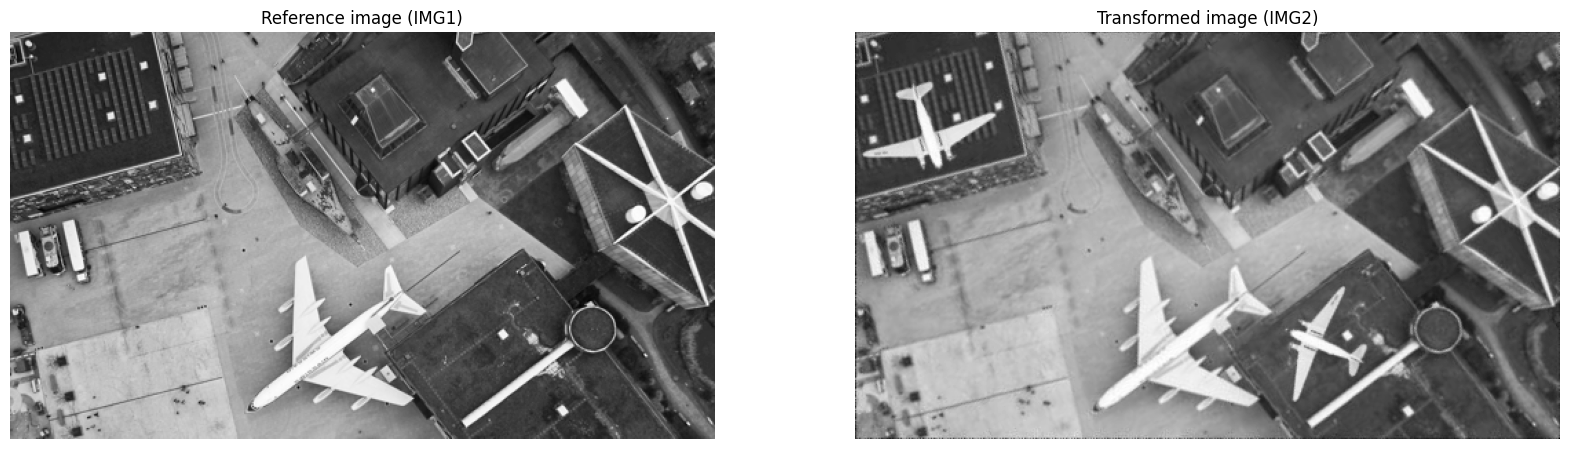

In [12]:
# Importing the images as numpy arrays
img1 = np.array(Image.open("IMG1.png"))
img2 = np.array(Image.open("IMG2.png"))

# The point correspondences given to us
xs1, ys1 = (93, 248)
xt1, yt1 = (29, 124)
xs2, ys2 = (328, 399)
xt2, yt2 = (157, 372)

# Feeding the given point correspondences as inputs to obtain the transform parameters
trf_params = estimate_params(xs1, ys1, xt1, yt1, xs2, ys2, xt2, yt2)
print("The estimated transformation parameters =", trf_params)

# Apply the transformations on IMG2 according to the estimated parameters
trf_img2 = transform_img(trf_params, img2)

# Reshaping the transformed image to the size of img1 (ie. Cropping out the extra black parts that aren't required)
img2_new = trf_img2[:img1.shape[0], :img1.shape[1]]

# Plotting all the images side by side
fig, ax = plt.subplots(1, 2, figsize=(20,20))
ax[0].imshow(img1, cmap='gray')
ax[0].set_title("Reference image (IMG1)")
ax[0].axis('off')

ax[1].imshow(img2_new, cmap='gray')
ax[1].set_title("Transformed image (IMG2)")
ax[1].axis('off')

plt.show()

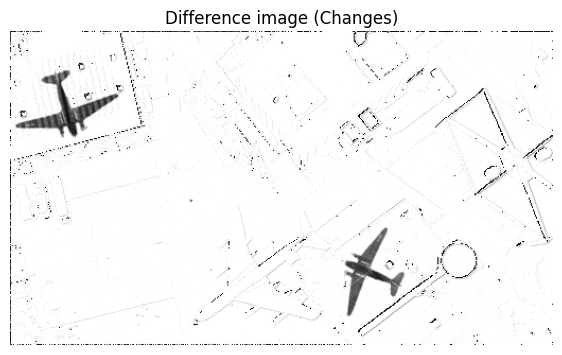

In [27]:
# Detecting changes by calculating the difference between the 2 images
changes = detect_changes(img1, img2_new, thresh=35)
plt.figure(figsize=(7, 7))
plt.imshow(changes, cmap='gray')
plt.title("Difference image (Changes)")
plt.axis('off')
plt.show()

# Observations
1. Clearly, the biggest difference are the 2 planes highlighted in the Difference image.
2. The estimated transform parameters are:
$cos(\theta)$ = 0.865, $sin(\theta)$ = -0.499. ie: $\theta$ $\approx$ = 30 degrees, $t_{x}$ = 72.32, $t_{y}$ = -137.06
3. The value of threshold (= 35) was obtained by trial and error
4. We require a threshold since taking a difference of the images doesn't work perfectly because of the use of bilinear interpolation in our transformations. This leads to slight blurring and hence change in intensities of the points.
5. The slight black borders in the difference image show that there is still a slight translation between IMG1 and the transformed IMG2, which might be another reason for the noise in the difference image.